In [ ]:
# Pytorch's tensors are similar to Numpy's ndarrays
!pip install torch

In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [ ]:
#Using MNIST Dataset for Training and Testing
training_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])    
)

## Dataset Generation
Creating a Custom dataset which consists of MNIST Image dataset, Random number and sum of the Image & a number.<br>
By creating a custom class for dataset we can combine MNIST dataset, the random number(one-hot-encoded form) and sum of both.

In [77]:
class MyTrainSet(Dataset):
  def __init__(self, dataset):
    #MNIST image dataset
    self.ImageData = dataset
    
    #one-hot-encoding of digits 0-9
    self.Integer = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]), num_classes=10)    

  def __getitem__(self,index):
    imagedata = self.ImageData[random.randint(0,59999)]
    image,label = imagedata
    RandNum = random.randint(0,9)
    EncodedIp = self.Integer[RandNum] 
    #EncodedOp = self.Output[RandNum+label]   
    return image,label,EncodedIp,(RandNum+label)

  def __len__(self):
    return len(self.ImageData)


In [78]:
Mydata = MyTrainSet(training_set)

## Data Visualization

label: 5
Encoded Input: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
Sum : 13


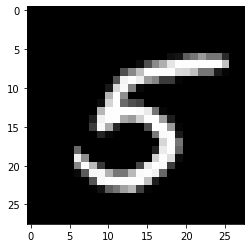

In [7]:
Image, label, EncodedIp,Sum_2 = next(iter(Mydata))
plt.imshow(Image.squeeze(), cmap='gray')
print('label:', label)
#print('Random Number:', RandNum)
print('Encoded Input:', EncodedIp)
#print('Encoded Output:', EncodedOp)
print('Sum :', Sum_2)

## Building a Neural network

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Input Image 28x28 @1, Kernel_size = 5(i.e 5x5) 
        # therefore output image size= 24x24 @10(outchanels) and a maxpooling with Kernel=2 and stride =2
        # The Output after Max-pooling will be 12x12@10
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)

        # Input Image 12x12 @10, Kernel_size = 5(i.e 5x5) 
        # therefore output image size= 8x8 @20(outchanels) and a maxpooling with Kernel=2 and stride =2
        # The Output after Max-pooling will be 4x4@20
        self.conv_layer2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv_dropout = nn.Dropout2d()


        # Input Image 4x4@20, therefore 20*4*4 i/ps   
        self.FCN1 = nn.Linear(in_features=320, out_features=50)

        #Another layer of FCN with i/ps = 50 and o/ps = 10  (10 Classes)
        self.out1 = nn.Linear(in_features=50, out_features=10)

        # We are combining the output of the previous layer(with one-hot-encoded form)
        self.FCN3 = nn.Linear(in_features=20, out_features=24)

        # A Output layer with o/ps = 19 (the maximum sum of two digits will 18(i.e 19 including 0))
        self.out2 = nn.Linear(in_features=24, out_features=19)

        self.opfromimage = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]), num_classes=10)

    def forward(self, inp1,inp2):
        # (1) input layer
        inp1 = inp1

        # (2) hidden conv layer
        N1 = self.conv_layer1(inp1)
        N1 = F.max_pool2d(N1, kernel_size=2, stride=2)
        N1 = F.relu(N1)
        
        # (3) hidden conv layer
        N1 = self.conv_layer2(N1)
        N1 = self.conv_dropout(N1)
        N1 = F.max_pool2d(N1, kernel_size=2, stride=2)
        N1 = F.relu(N1)        

        # (4) hidden linear layer
        N1 = N1.view(-1, 320)
        N1 = self.FCN1(N1)
        N1 = F.relu(N1)        

        N1 = self.out1(N1)
        N1 = F.log_softmax(N1,dim=1) 
        
        # Generating i/p for nxt layer with previous layer o/ps
        new_ip = self.opfromimage[N1.argmax(dim=1)]
        
        
        Combined = torch.cat((new_ip, inp2), dim=1)
        Combined = F.relu(Combined)

        
        # (6) hidden linear layer
        Combined = self.FCN3(Combined)
        Combined = F.relu(Combined)

        # (7) hidden linear layer
        Combined = self.out2(Combined)
        Combined = F.softmax(Combined,dim=1)

        return N1,Combined

In [36]:
network = Network()
network

Network(
  (conv_layer1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv_dropout): Dropout2d(p=0.5, inplace=False)
  (FCN1): Linear(in_features=320, out_features=50, bias=True)
  (out1): Linear(in_features=50, out_features=10, bias=True)
  (FCN3): Linear(in_features=20, out_features=24, bias=True)
  (out2): Linear(in_features=24, out_features=19, bias=True)
)

label: 0
Encoded Input: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
Sum : 6
Predicted Image : tensor([0])
Predicted Sum : tensor([6])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


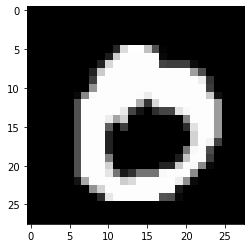

In [37]:
Sample = next(iter(Mydata))
Image, label, EncodedIp,Sum_2 = Sample
plt.imshow(Image.squeeze(), cmap='gray')
print('label:', label)
#print('Random Number:', RandNum)
print('Encoded Input:', EncodedIp)
#print('Encoded Output:', EncodedOp)
print('Sum :', Sum_2)

network = Network()
EncodedIp = torch.tensor(EncodedIp,dtype=torch.float32)
pred_image,sum = network(Image.unsqueeze(0),EncodedIp.unsqueeze(0))
#OP1 = pred[0,:10]
#OP2 = pred[0,10:]
print('Predicted Image :',pred_image.argmax(dim=1))
print('Predicted Sum :',sum.argmax(dim=1))


In [38]:
data_loader = torch.utils.data.DataLoader(
    Mydata, 
    batch_size=100
)

batch = next(iter(data_loader))
len(batch)

4

In [39]:
def get_num_correct(X, Y):
  return X.argmax(dim=1).eq(Y).sum().item()

In [40]:
import torch.optim as optim
torch.set_grad_enabled(True) # remember we turned off the gradients?

In [41]:
optimizer = optim.Adam(network.parameters(), lr=0.01)

## Tarining a Network

In [ ]:
train_loader = torch.utils.data.DataLoader(Mydata, batch_size=1000)
optimizer = optim.Adam(network.parameters(), lr=0.05)

for epoch in range(200):

    total_loss_1 = 0
    total_loss_2 = 0
    total_correct = 0
    total_correct_sum = 0

    for batch in train_loader: # Get Batch
        Image, label, EncodedIp,Sum_2 = batch
        EncodedIp = torch.tensor(EncodedIp,dtype=torch.float32)
        pred_image, Sum_3 = network(Image,EncodedIp)
                
        loss1 = F.cross_entropy(pred_image, label)
        loss2 = F.cross_entropy(Sum_3, Sum_2)
        Loss = loss1 + loss2
        
        optimizer.zero_grad()
        Loss.backward() # Calculate Gradients
        #loss2.backward()
        optimizer.step() # Update Weights        

        total_loss_1 += Loss.item()
        #total_loss_2 += loss2.item()
               
        total_correct += get_num_correct(pred_image, label)
        total_correct_sum +=get_num_correct(Sum_3,Sum_2)
        #print(
        #    "total_correct images:", total_correct, 
        #    "total_correct Sum:", total_correct_sum
        #)

    ImageAccuracy = (total_correct/60000)*100;
    SumAccuracy = (total_correct_sum/60000)*100;
    print(
        "\n\nEpoch: ", epoch,
        "\nBatch Size: ",1000,
        "\nPredicted image Count: ", total_correct,
        "Predicted sum Count: ", total_correct_sum,
        #"loss_1:", total_loss1,
        "\nTotal loss:", total_loss_1,
        "\nImage Accuracy: ",ImageAccuracy,"Sum Accuracy: ", SumAccuracy
    )

## Evaluating

We are using same strategy used for generating the training dataset for Test dataset

In [61]:
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])    
)

In [74]:
class MyTestSet(Dataset):
  def __init__(self, dataset):
    #MNIST image dataset
    self.ImageData = dataset
    #one-hot-encoding of digits 0-9
    self.Integer = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]), num_classes=10)
    #self.Output = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18]), num_classes=19)

  def __getitem__(self,index):
    imagedata = self.ImageData[random.randint(0,9999)]
    image,label = imagedata
    RandNum = random.randint(0,9)
    EncodedIp = self.Integer[RandNum] 
    #EncodedOp = self.Output[RandNum+label]   
    return image,label,EncodedIp,(RandNum+label)

  def __len__(self):
    return len(self.ImageData)

In [75]:
MyTestData = MyTestSet(test_set)

In [76]:
test_loader = torch.utils.data.DataLoader(MyTestData, batch_size=100)
total_correct = 0
total_correct_sum = 0
for batch in test_loader: # Get Batch
  Image, label, EncodedIp,Sum_2 = batch
  EncodedIp = torch.tensor(EncodedIp,dtype=torch.float32)
  pred_image, Sum_3 = network(Image,EncodedIp)
  total_correct += get_num_correct(pred_image, label)
  total_correct_sum +=get_num_correct(Sum_3,Sum_2)
  TestImageAccuracy = (total_correct/10000)*100;
  TestSumAccuracy = (total_correct_sum/10000)*100;
print(
        "\nPredicted image Count: ", total_correct,
        "Predicted sum Count: ", total_correct_sum,        
        "\nImage Accuracy: ",TestImageAccuracy,"Sum Accuracy: ", TestSumAccuracy
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



Predicted image Count:  8976 Predicted sum Count:  7261 
Image Accuracy:  89.75999999999999 Sum Accuracy:  72.61


## Results

Training Set : 60000<br>
Test Set : 10000
<br><br>
### Accuracy
Image predicted correctly = 89%<br>
Sum predicted correctly = 72%

